# Cohort Retention Analysis

**Purpose**: Analyze user retention by signup cohort over time | **Metric**: Retention rate = users_active / cohort_size


In [1]:
# Imports
import os
import sys
from pathlib import Path
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Add src to path for importing cohort_analysis module
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root / "src"))

# Configuration
DB_PATH = project_root / "analytics.duckdb"
SQL_ANALYTICS_DIR = project_root / "sql" / "analytics"
RETENTION_QUERY_FILE = SQL_ANALYTICS_DIR / "05_cohort_retention_rates.sql"

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded successfully")
print(f"Database path: {DB_PATH}")
print(f"Database exists: {DB_PATH.exists()}")

# Helper function to check if table exists
def table_exists(conn, table_name):
    """Check if a table exists in DuckDB"""
    try:
        result = conn.execute(f"SELECT COUNT(*) FROM {table_name}").fetchone()
        return True
    except:
        return False


Libraries loaded successfully
Database path: W:\CodeBase\Resume-Projects\E-commerce-Product-Analytics\analytics.duckdb
Database exists: True


## Setup: Check Required Tables

**Required**: `user_sessions`, `funnel_sessions`, `purchase_cohorts`

**Create tables**: Run `python scripts/materialize_tables.py` or execute SQL files in order:
1. `sql/analytics/01_sessionization.sql`
2. `sql/analytics/02_funnel.sql`
3. `sql/analytics/03_cohorts.sql`

**Prerequisites**: Load raw data first with `python src/load_to_db.py`


In [2]:
# Connect to DuckDB and check table status
conn = duckdb.connect(str(DB_PATH))

# Check raw tables first (prerequisites)
print("="*60)
print("CHECKING RAW TABLES (Prerequisites)")
print("="*60)

raw_tables = ['users_raw', 'events_raw', 'orders_raw']
raw_status = {}
for table_name in raw_tables:
    exists = table_exists(conn, table_name)
    raw_status[table_name] = exists
    status = "✓ EXISTS" if exists else "✗ MISSING"
    print(f"  {table_name}: {status}")

missing_raw = [t for t, exists in raw_status.items() if not exists]

# Check analytics tables
print("\n" + "="*60)
print("CHECKING ANALYTICS TABLES")
print("="*60)

tables_needed = {
    'user_sessions': {
        'sql_file': '01_sessionization.sql',
        'description': 'Sessionized events (30-min timeout)',
        'depends_on': ['events_raw']
    },
    'funnel_sessions': {
        'sql_file': '02_funnel.sql',
        'description': 'Session-level funnel flags',
        'depends_on': ['user_sessions']
    },
    'purchase_cohorts': {
        'sql_file': '03_cohorts.sql',
        'description': 'Cohort base table for retention',
        'depends_on': ['users_raw', 'orders_raw']
    }
}

tables_status = {}
for table_name, info in tables_needed.items():
    exists = table_exists(conn, table_name)
    tables_status[table_name] = exists
    status = "✓ EXISTS" if exists else "✗ MISSING"
    print(f"\n{table_name}: {status}")
    print(f"  Description: {info['description']}")
    print(f"  SQL File: sql/analytics/{info['sql_file']}")
    print(f"  Depends on: {', '.join(info['depends_on'])}")

# Check for missing tables
missing_tables = [t for t, exists in tables_status.items() if not exists]

print("\n" + "="*60)
print("SUMMARY")
print("="*60)

if missing_raw:
    print(f"⚠ WARNING: {len(missing_raw)} raw table(s) are missing!")
    print("\nPlease load raw data first:")
    print("   python src/load_to_db.py")
    print("\nThis will create: users_raw, events_raw, orders_raw")
    print("\nPrerequisites:")
    print("   - Generate data: python src/data_generator.py")
    print("   - Load to DB: python src/load_to_db.py")

if missing_tables:
    if not missing_raw:  # Only show SQL instructions if raw tables exist
        print(f"\n⚠ WARNING: {len(missing_tables)} analytics table(s) are missing!")
        print("\nPlease run the SQL scripts in order:")
        for table_name in ['user_sessions', 'funnel_sessions', 'purchase_cohorts']:
            if table_name in missing_tables:
                sql_file = tables_needed[table_name]['sql_file']
                print(f"   - sql/analytics/{sql_file}")
        print("\nSee instructions in the markdown cell above for how to run SQL files.")
elif not missing_raw:
    print("✓ All required tables exist. Ready to proceed!")

print("="*60)
conn.close()


CHECKING RAW TABLES (Prerequisites)
  users_raw: ✓ EXISTS
  events_raw: ✓ EXISTS
  orders_raw: ✓ EXISTS

CHECKING ANALYTICS TABLES

user_sessions: ✓ EXISTS
  Description: Sessionized events (30-min timeout)
  SQL File: sql/analytics/01_sessionization.sql
  Depends on: events_raw

funnel_sessions: ✓ EXISTS
  Description: Session-level funnel flags
  SQL File: sql/analytics/02_funnel.sql
  Depends on: user_sessions

purchase_cohorts: ✓ EXISTS
  Description: Cohort base table for retention
  SQL File: sql/analytics/03_cohorts.sql
  Depends on: users_raw, orders_raw

SUMMARY
✓ All required tables exist. Ready to proceed!


In [3]:
# import duckdb
# con = duckdb.connect("analytics.duckdb")

# con.execute("""
# SELECT
#   COUNT(*) AS sessions,
#   SUM(purchase) AS purchases
# FROM funnel_sessions
# """).fetchdf()


## 1. Load Cohort Retention Data

Load retention data from DuckDB using the retention rates query.


In [ ]:
# Load SQL query
with open(RETENTION_QUERY_FILE, 'r') as f:
    retention_query = f.read()

# Connect to DuckDB and execute query
conn = duckdb.connect(str(DB_PATH))

# Verify purchase_cohorts exists before querying
if not table_exists(conn, 'purchase_cohorts'):
    print("ERROR: purchase_cohorts table does not exist!")
    print("Please run the setup cell above to create required tables.")
    conn.close()
    raise Exception("purchase_cohorts table missing. Run setup cell first.")

try:
    retention_df = conn.execute(retention_query).df()
    conn.close()
    
    # Check if we got data
    if len(retention_df) == 0:
        print("WARNING: Query returned 0 rows. Check if orders_raw has data.")
    else:
        # Convert cohort_week to datetime
        retention_df['cohort_week'] = pd.to_datetime(retention_df['cohort_week'])
        
        print(f"✓ Loaded {len(retention_df):,} retention records")
        print(f"\nData shape: {retention_df.shape}")
        print(f"\nColumns: {list(retention_df.columns)}")
        print(f"\nFirst few rows:")
        retention_df.head(10)  # Will display automatically in Jupyter
        
except Exception as e:
    conn.close()
    print(f"ERROR executing retention query: {e}")
    raise


✓ Loaded 2,012 retention records

Data shape: (2012, 5)

Columns: ['cohort_week', 'cohort_index', 'users_active', 'cohort_size', 'retention_rate']

First few rows:


## 2. Descriptive Statistics

Understand the distribution of cohort sizes and retention rates.


In [ ]:
# Cohort sizes
cohort_sizes = retention_df.groupby('cohort_week')['cohort_size'].first()
print("="*60)
print("COHORT SIZES")
print("="*60)
print(f"Number of cohorts: {len(cohort_sizes)}")
print(f"\nCohort size statistics:")
print(cohort_sizes.describe())
print(f"\nTotal users across all cohorts: {cohort_sizes.sum():,}")

# Retention rate distribution
print("\n" + "="*60)
print("RETENTION RATE DISTRIBUTION")
print("="*60)
print(retention_df['retention_rate'].describe())
print(f"\nRetention rate range: {retention_df['retention_rate'].min():.4f} - {retention_df['retention_rate'].max():.4f}")

# Periods tracked
print("\n" + "="*60)
print("PERIODS TRACKED")
print("="*60)
max_period = retention_df['cohort_index'].max()
print(f"Maximum cohort_index (weeks tracked): {max_period}")
print(f"Number of unique periods: {retention_df['cohort_index'].nunique()}")


COHORT SIZES
Number of cohorts: 99

Cohort size statistics:
count     99.000000
mean      46.767677
std       27.811255
min        1.000000
25%       22.000000
50%       51.000000
75%       69.500000
max      105.000000
Name: cohort_size, dtype: float64

Total users across all cohorts: 4,630

RETENTION RATE DISTRIBUTION
count    2012.000000
mean        0.406672
std         0.464477
min         0.009500
25%         0.053600
50%         0.200000
75%         0.654425
max         3.250000
Name: retention_rate, dtype: float64

Retention rate range: 0.0095 - 3.2500

PERIODS TRACKED
Maximum cohort_index (weeks tracked): 44
Number of unique periods: 39


**Insights**: Cohort sizes vary (check mean vs median). Retention rates 0-100%. Larger cohorts may indicate campaigns/seasonality.


In [ ]:
# Create retention matrix for visualization
retention_matrix = retention_df.pivot_table(
    index='cohort_week',
    columns='cohort_index',
    values='retention_rate',
    fill_value=np.nan
)

# Sort chronologically
retention_matrix = retention_matrix.sort_index().sort_index(axis=1)

print(f"Retention matrix shape: {retention_matrix.shape}")
print(f"Cohorts: {retention_matrix.shape[0]}, Periods: {retention_matrix.shape[1]}")


Retention matrix shape: (99, 39)
Cohorts: 99, Periods: 39


## Retention Heatmap

Retention by cohort and period. Darker = higher retention.


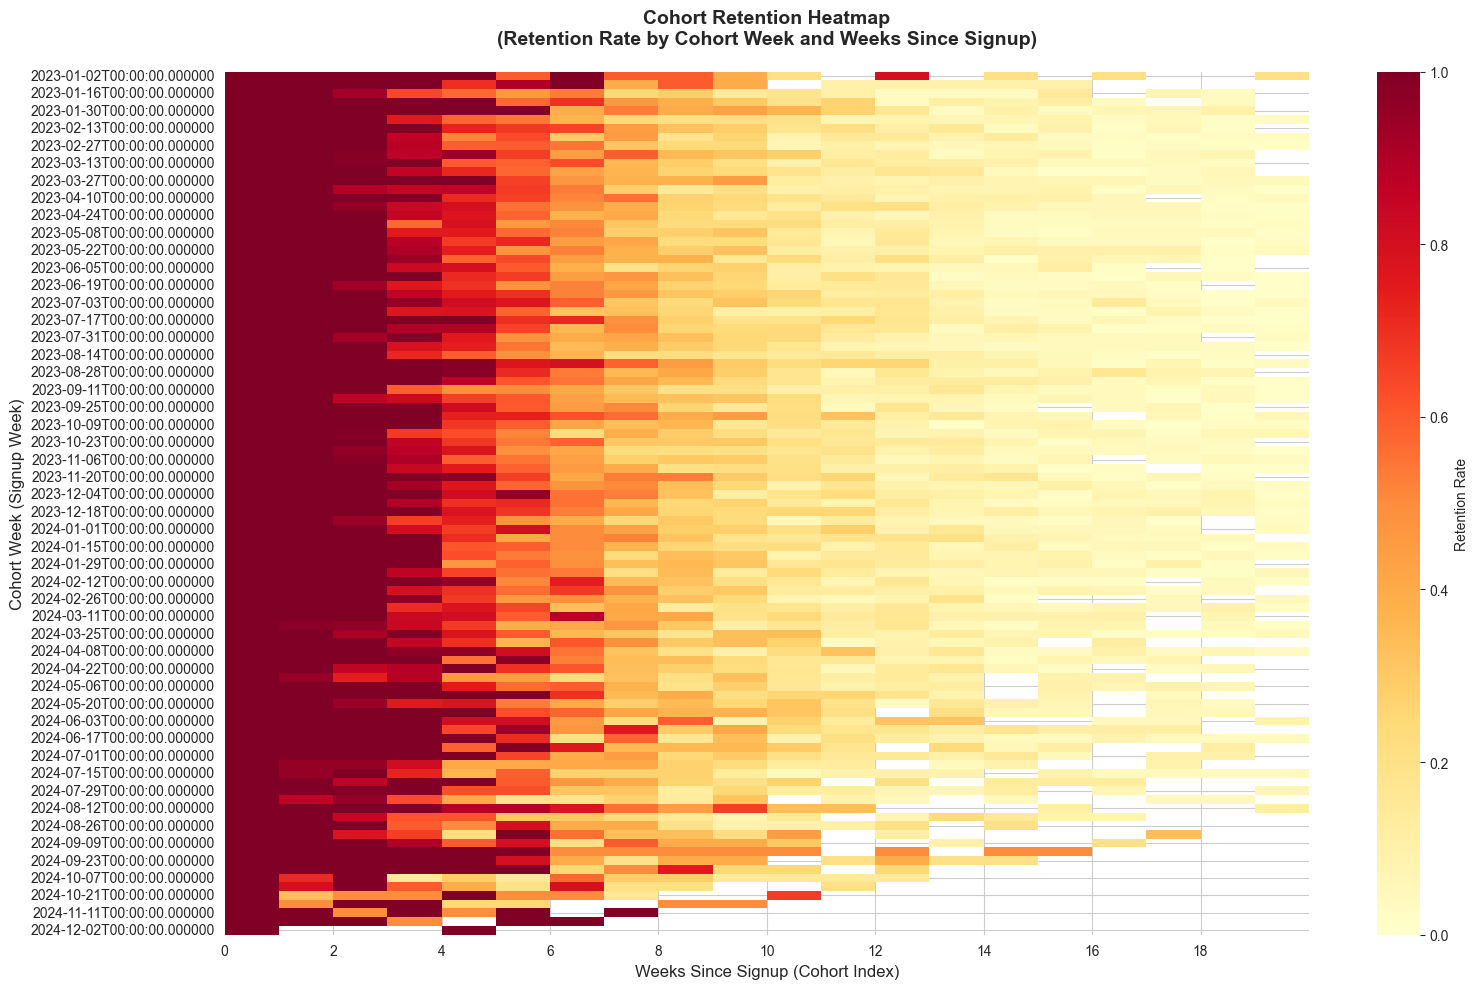

Heatmap shows retention patterns:
- Horizontal: Weeks since signup (0 = signup week)
- Vertical: Different cohorts (signup weeks)
- Color intensity: Retention rate (darker = higher retention)


In [7]:
# Create heatmap
fig, ax = plt.subplots(figsize=(16, 10))

# Limit to first 20 periods for readability (adjust as needed)
matrix_display = retention_matrix.iloc[:, :20]

sns.heatmap(
    matrix_display,
    annot=False,  # Set to True to show values (can be cluttered)
    fmt='.2f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Retention Rate'},
    vmin=0,
    vmax=1.0,
    ax=ax
)

ax.set_title('Cohort Retention Heatmap\n(Retention Rate by Cohort Week and Weeks Since Signup)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Weeks Since Signup (Cohort Index)', fontsize=12)
ax.set_ylabel('Cohort Week (Signup Week)', fontsize=12)

# Format x-axis to show fewer labels
ax.set_xticks(range(0, matrix_display.shape[1], 2))
ax.set_xticklabels(range(0, matrix_display.shape[1], 2))

plt.tight_layout()
plt.show()

print("Heatmap shows retention patterns:")
print("- Horizontal: Weeks since signup (0 = signup week)")
print("- Vertical: Different cohorts (signup weeks)")
print("- Color intensity: Retention rate (darker = higher retention)")


**Patterns**: Diagonal decay (retention drops over time), vertical stripes (cohort differences), horizontal patterns (period effects), sharp drop-offs (retention cliffs).

**Questions**: Are newer cohorts better? Seasonality? When do users churn?


## Retention Curves

Retention decay over time for selected cohorts.


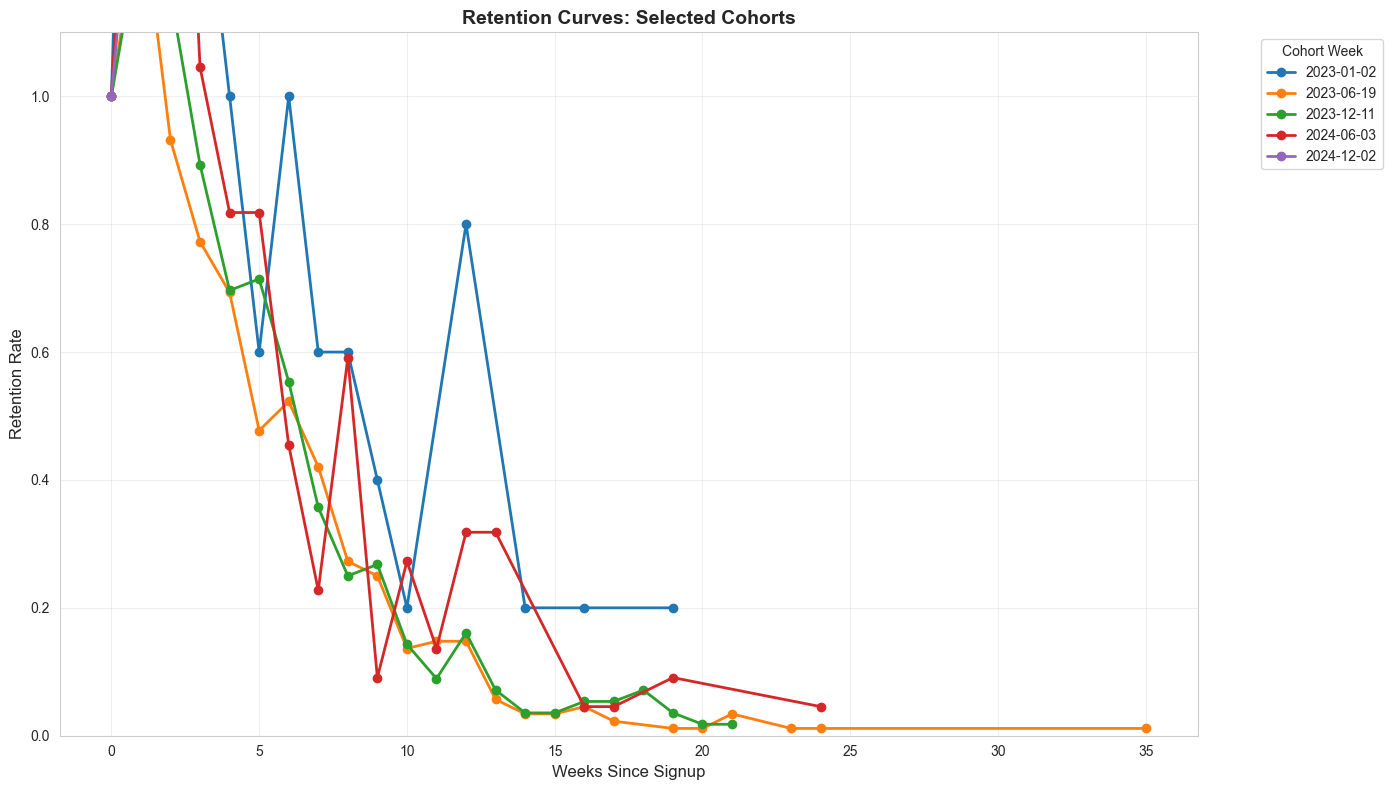

Selected 5 cohorts for comparison


In [8]:
# Select representative cohorts (early, middle, late)
cohort_weeks = retention_matrix.index
n_cohorts = len(cohort_weeks)

# Select cohorts at different time points
selected_indices = [
    0,  # First cohort
    n_cohorts // 4,  # 25% through
    n_cohorts // 2,  # Middle
    3 * n_cohorts // 4,  # 75% through
    n_cohorts - 1  # Last cohort
]

selected_cohorts = [cohort_weeks[i] for i in selected_indices if i < n_cohorts]

# Plot retention curves
fig, ax = plt.subplots(figsize=(14, 8))

for cohort_week in selected_cohorts:
    cohort_data = retention_matrix.loc[cohort_week]
    # Remove NaN values for cleaner plot
    valid_data = cohort_data.dropna()
    
    ax.plot(
        valid_data.index,
        valid_data.values,
        marker='o',
        label=cohort_week.strftime('%Y-%m-%d'),
        linewidth=2,
        markersize=6
    )

ax.set_xlabel('Weeks Since Signup', fontsize=12)
ax.set_ylabel('Retention Rate', fontsize=12)
ax.set_title('Retention Curves: Selected Cohorts', fontsize=14, fontweight='bold')
ax.legend(title='Cohort Week', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

print(f"Selected {len(selected_cohorts)} cohorts for comparison")


**Analysis**: Steepness (churn rate), plateaus (stabilization), cohort differences, shape (exponential/linear/step).

**Implications**: Steep early drop = users not finding value. Gradual decline = natural attrition. Plateaus = engaged users.


## Mean vs Median Retention

Compare mean/median to identify distribution shape and outliers.


RETENTION BY PERIOD (Weeks Since Signup)
 cohort_index   mean  median    std    min    max
            0 1.0000  1.0000 0.0000 1.0000 1.0000
            1 1.4891  1.4920 0.4026 0.3333 3.2500
            2 1.1944  1.1420 0.2892 0.5000 2.0588
            3 0.9488  0.9043 0.2576 0.1429 1.7500
            4 0.7672  0.7404 0.3095 0.2222 3.0000
            5 0.6455  0.6000 0.2231 0.1429 1.5000
            6 0.5178  0.4843 0.2651 0.1818 2.5000
            7 0.3932  0.3784 0.1283 0.1667 1.0000
            8 0.3091  0.2892 0.1066 0.1250 0.7500
            9 0.2613  0.2467 0.0991 0.0769 0.6667
           10 0.1977  0.1837 0.0934 0.0455 0.6667
           11 0.1477  0.1364 0.0665 0.0303 0.3333
           12 0.1399  0.1242 0.1005 0.0313 0.8000
           13 0.1028  0.0934 0.0523 0.0145 0.3182
           14 0.0808  0.0714 0.0635 0.0139 0.5000


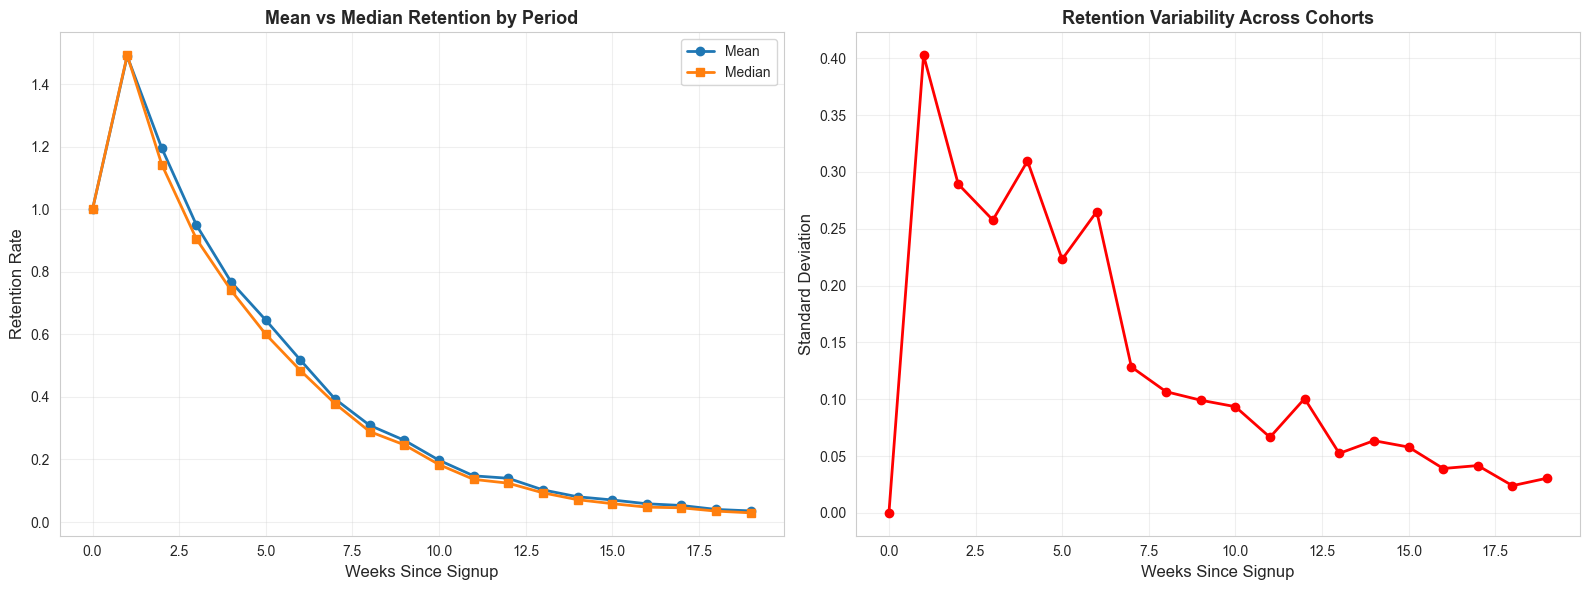

In [9]:
# Calculate mean and median retention by period (cohort_index)
retention_by_period = retention_df.groupby('cohort_index').agg({
    'retention_rate': ['mean', 'median', 'std', 'min', 'max']
}).round(4)

retention_by_period.columns = ['mean', 'median', 'std', 'min', 'max']
retention_by_period = retention_by_period.reset_index()

print("="*60)
print("RETENTION BY PERIOD (Weeks Since Signup)")
print("="*60)
print(retention_by_period.head(15).to_string(index=False))

# Visualize mean vs median
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Mean vs Median comparison
periods_to_plot = retention_by_period['cohort_index'].head(20)
ax1.plot(periods_to_plot, retention_by_period['mean'].head(20), 
         marker='o', label='Mean', linewidth=2, markersize=6)
ax1.plot(periods_to_plot, retention_by_period['median'].head(20), 
         marker='s', label='Median', linewidth=2, markersize=6)
ax1.set_xlabel('Weeks Since Signup', fontsize=12)
ax1.set_ylabel('Retention Rate', fontsize=12)
ax1.set_title('Mean vs Median Retention by Period', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Standard deviation (variability across cohorts)
ax2.plot(periods_to_plot, retention_by_period['std'].head(20), 
         marker='o', color='red', linewidth=2, markersize=6)
ax2.set_xlabel('Weeks Since Signup', fontsize=12)
ax2.set_ylabel('Standard Deviation', fontsize=12)
ax2.set_title('Retention Variability Across Cohorts', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


**Insights**: Mean > Median = right-skewed (some cohorts excel). Mean < Median = left-skewed (some underperform). Mean ≈ Median = symmetric.

**Std Dev**: High = cohort variation (external factors). Low = consistent patterns.

**Action**: Mean >> median → investigate top performers. Mean << median → find underperformers. High variability → check seasonality/campaigns.


## Early vs Late Cohort Behavior

Compare older vs recent signup cohorts to identify trends.


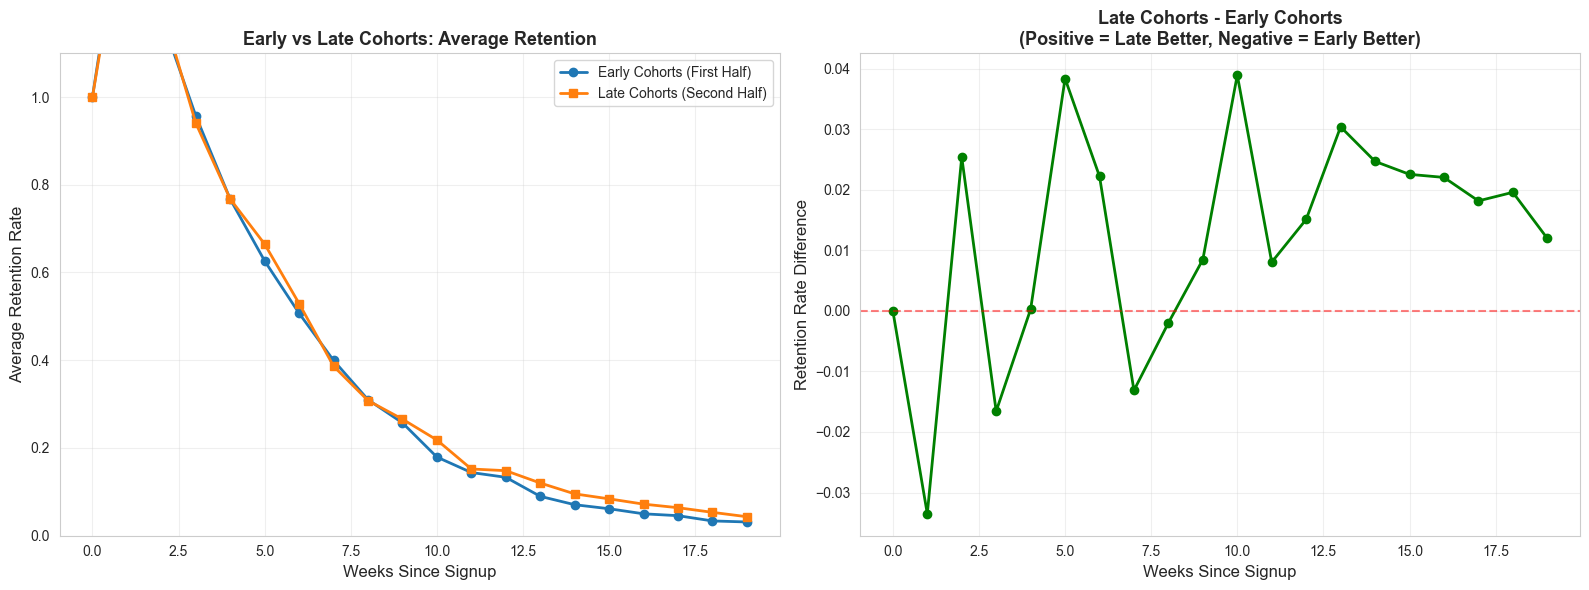

EARLY vs LATE COHORT COMPARISON
Early cohorts: 49 cohorts
Late cohorts: 50 cohorts

Average retention at period 0 (signup week):
  Early: 1.0000
  Late:  1.0000
  Difference: 0.0000

Average retention at period 4 (4 weeks after signup):
  Early: 0.7671
  Late:  0.7674
  Difference: 0.0003


In [10]:
# Split cohorts into early (first half) and late (second half)
n_cohorts = len(retention_matrix)
early_cohorts = retention_matrix.iloc[:n_cohorts//2]
late_cohorts = retention_matrix.iloc[n_cohorts//2:]

# Calculate average retention by period for each group
early_avg = early_cohorts.mean(axis=0)
late_avg = late_cohorts.mean(axis=0)

# Compare
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Average retention curves
periods_to_compare = early_avg.index[:20]
ax1.plot(periods_to_compare, early_avg.iloc[:20], 
         marker='o', label='Early Cohorts (First Half)', linewidth=2, markersize=6)
ax1.plot(periods_to_compare, late_avg.iloc[:20], 
         marker='s', label='Late Cohorts (Second Half)', linewidth=2, markersize=6)
ax1.set_xlabel('Weeks Since Signup', fontsize=12)
ax1.set_ylabel('Average Retention Rate', fontsize=12)
ax1.set_title('Early vs Late Cohorts: Average Retention', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.1)

# Difference (late - early)
difference = late_avg - early_avg
ax2.plot(periods_to_compare, difference.iloc[:20], 
         marker='o', color='green', linewidth=2, markersize=6)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Weeks Since Signup', fontsize=12)
ax2.set_ylabel('Retention Rate Difference', fontsize=12)
ax2.set_title('Late Cohorts - Early Cohorts\n(Positive = Late Better, Negative = Early Better)', 
              fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("="*60)
print("EARLY vs LATE COHORT COMPARISON")
print("="*60)
print(f"Early cohorts: {len(early_cohorts)} cohorts")
print(f"Late cohorts: {len(late_cohorts)} cohorts")
print(f"\nAverage retention at period 0 (signup week):")
print(f"  Early: {early_avg.iloc[0]:.4f}")
print(f"  Late:  {late_avg.iloc[0]:.4f}")
print(f"  Difference: {difference.iloc[0]:.4f}")
print(f"\nAverage retention at period 4 (4 weeks after signup):")
if len(early_avg) > 4:
    print(f"  Early: {early_avg.iloc[4]:.4f}")
    print(f"  Late:  {late_avg.iloc[4]:.4f}")
    print(f"  Difference: {difference.iloc[4]:.4f}")


## Sharp Drop-off Points

Identify critical churn periods where retention drops most dramatically.


SHARPEST RETENTION DROPS
Top 5 periods with largest absolute retention drops:
 cohort_index   mean  retention_drop  pct_drop
            1 1.4891          0.4891 48.910000
           34 0.0250          0.0104 71.232877
           30 0.0230          0.0088 61.971831
           39 0.0156          0.0036 30.000000
           27 0.0256          0.0026 11.304348


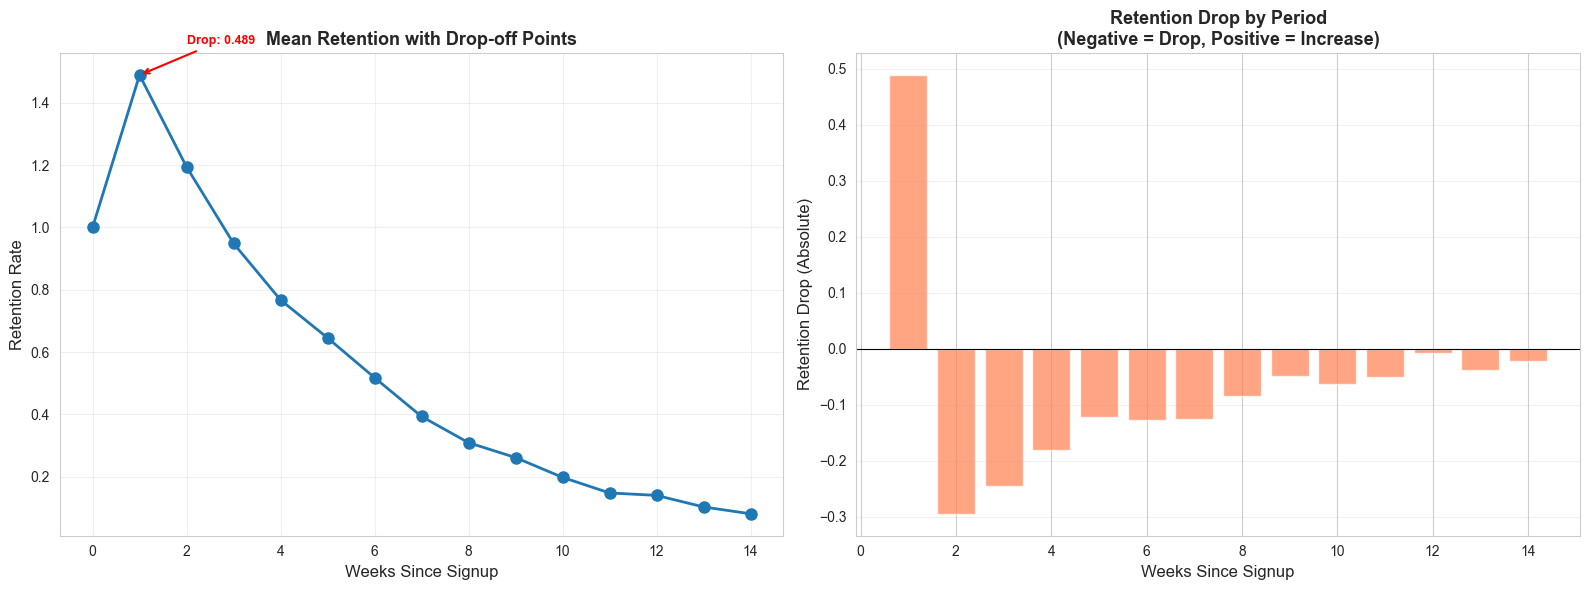

In [ ]:
# Calculate retention drop (change from previous period)
retention_by_period['retention_drop'] = retention_by_period['mean'].diff()

# Calculate percentage drop
retention_by_period['pct_drop'] = (
    retention_by_period['retention_drop'] / 
    retention_by_period['mean'].shift(1) * 100
)

# Identify largest drops
largest_drops = retention_by_period.nlargest(5, 'retention_drop')[['cohort_index', 'mean', 'retention_drop', 'pct_drop']]

print("="*60)
print("SHARPEST RETENTION DROPS")
print("="*60)
print("Top 5 periods with largest absolute retention drops:")
print(largest_drops.to_string(index=False))

# Visualize retention drops
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Retention curve with drop annotations
periods_plot = retention_by_period['cohort_index'].head(15)
ax1.plot(periods_plot, retention_by_period['mean'].head(15), 
         marker='o', linewidth=2, markersize=8, label='Mean Retention')
ax1.set_xlabel('Weeks Since Signup', fontsize=12)
ax1.set_ylabel('Retention Rate', fontsize=12)
ax1.set_title('Mean Retention with Drop-off Points', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Annotate largest drops
for idx, row in largest_drops.head(3).iterrows():
    period = int(row['cohort_index'])
    if period <= 15:
        ax1.annotate(f'Drop: {row["retention_drop"]:.3f}', 
                    xy=(period, row['mean']), 
                    xytext=(period+1, row['mean']+0.1),
                    arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                    fontsize=9, color='red', fontweight='bold')

# Retention drop magnitude
ax2.bar(periods_plot, retention_by_period['retention_drop'].head(15), 
        color='coral', alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xlabel('Weeks Since Signup', fontsize=12)
ax2.set_ylabel('Retention Drop (Absolute)', fontsize=12)
ax2.set_title('Retention Drop by Period\n(Negative = Drop, Positive = Increase)', 
              fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


**Critical Periods**: Week 0→1 (first week drop), Week 1→2 (early engagement), Week 2→4 (mid-term churn).

**Actions**: Large 0→1 drop → improve onboarding. Large 1→2 drop → enhance discovery. Steady decline → focus on long-term value.

**Interventions**: Target high-risk periods with re-engagement, identify successful user patterns, A/B test at drop-off points.


## Summary & Key Insights

**Findings**: [Fill after analysis]
- Overall retention pattern and trends
- Cohort differences (early vs late, best vs worst)
- Critical drop-off points and intervention opportunities
- Business recommendations (product, marketing, engagement)

**Next Steps**: Investigate top/underperforming cohorts, design drop-off interventions, set up retention monitoring
